# Pre-Processing Data

First, install the required R packages if not done already. See [Installing Required R Packages.](../00_Installing_Required_R_Packages.ipynb)

This notebook is meant to be viewed after the Data Exploration notebook and is a continuation of said exploration. In this notebook we will address some of the issues we've identified in our data exploration for model development and explore the ways we could address said issues.

We will perform the following tasks:

* Removing columns with large missingness
* Data Partitioning
* Imputation
* Rare Event Handling
* Variable Encoding
* Variable Scaling
* Feature Creation
* Feature Selection

## Loading Libraries

In the next section we will load the necessary libraries and dataset that will be used throughout this project.

In [1]:
library(tidyverse)
library(caret)
library(caTools)
library(gridExtra)
library(rpart)
library(readr)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.2     ✔ tibble    3.2.1
✔ lubridate 1.9.4     ✔ tidyr     1.3.1
✔ purrr     1.0.4     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
Loading required package: lattice


Attaching package: ‘caret’


The following object is masked from ‘package:purrr’:

    lift



Attaching package: ‘gridExtra’


The following object is masked from ‘package:dplyr’:

    combine




In [2]:
# Imports the dataset and relevels factors

churn_df <- read.csv("../../data/output/customer_churn_abt.csv")
churn_df$customerGender <- relevel(as.factor(churn_df$customerGender), ref = "U")
churn_df$demHomeOwner <- relevel(as.factor(churn_df$demHomeOwner), ref = "Unknown")
churn_df$customerSubscrStat <- relevel(as.factor(churn_df$customerSubscrStat), ref = "Member")

### Removing Columns

Removes strongly correlated columns, as well as columns involved in computing composite columns.

In [3]:
#Drop columns in place

churn_df <- churn_df %>% select(-avgDiscountValue12, -intAdExposureCountAll)

In [4]:
# Define threshold (50% of total rows)

threshold <- 0.5 * nrow(churn_df)

# Drop columns with more than 50% missing values

churn_df <- churn_df %>% 
  select(where(~ sum(is.na(.)) < threshold))

### Column Names

Over the next few code cells new variables will be created to quickly reference columns belonging to a given group based on type, missingness, etc.

In [5]:
# Creates lists representing the input variables and target

target <- "LostCustomer"
ID <- "ID"
inputs <- setdiff(names(churn_df), c(target, ID))
numerics <- setdiff(names(churn_df)[sapply(churn_df, is.numeric)], c(target, ID))
categoricals <- names(churn_df)[sapply(churn_df, is.character) | sapply(churn_df, is.factor)]

In [6]:
# Compute skewness and kurtosis for all numeric variables

numeric_cols <- churn_df[,numerics]
skewness <- sapply(numeric_cols, function(x) psych::skew(x))
kurtosis <- sapply(numeric_cols, function(x) psych::kurtosi(x))

#Selecting highly non-normal columns

high_skewness <- skewness[abs(skewness) > 3]
high_kurtosis <- kurtosis[abs(kurtosis) > 3]

# Creates list of skewed columns

skewed_cols <- intersect(names(high_skewness), names(high_kurtosis))


In [7]:
# Displays the proportion of missing values

missing <- colSums(is.na(churn_df))
missing <- missing[missing > 0] / nrow(churn_df)
missing_list <- names(missing)

### Data Partitioning

Partitions data into stratified training and testing partitions using an 80/20 split.

In [8]:
# Split the data into training and testing sets (80% training, 20% testing)

set.seed(45) 
split <- sample.split(churn_df[[target]], SplitRatio = 0.8)

trainID <- churn_df[split, ID]
testID <- churn_df[!split, ID]
X_train <- churn_df[split, inputs]
X_test <- churn_df[!split, inputs]
y_train <- churn_df[split, target]
y_test <- churn_df[!split, target]



In [9]:
# For training data

cat("The training partition inputs have dimensions:", nrow(X_train), "by", ncol(X_train), "and the targets have a length of", length(y_train), "\n")

# For testing/validation data

cat("The validation partition inputs have dimensions:", nrow(X_test), "by", ncol(X_test),"and the targets have a length of", length(y_test), "\n")


The training partition inputs have dimensions: 4000 by 24 and the targets have a length of 4000 
The validation partition inputs have dimensions: 1000 by 24 and the targets have a length of 1000 


In [10]:
# Verifies that target distributions are close to one another

y_train_dist <- prop.table(table(y_train))
y_test_dist <- prop.table(table(y_test))

cat("The difference in the target distribution proportion between both partitions is:", "\n\n")
difference <- y_train_dist - y_test_dist
print(difference)

The difference in the target distribution proportion between both partitions is: 

y_train
       0        1 
 0.00025 -0.00025 


### Imputation

Imputes missing values with the median given the distribution of the columns with missingness.

In [11]:
# Creates, fits, and applies a simple imputer 

preprocessor <- preProcess(X_train[, numerics], method = "medianImpute")
X_train[, numerics] <- predict(preprocessor, X_train[, numerics])

In [12]:
# Imputes missing value in the testing partition 

X_test[, numerics] <- predict(preprocessor, X_test[, numerics])

In [13]:
# Displays the number of missing values in all the listed columns

data.frame(preprocessor$median) 

,preprocessor.median
,<dbl>
regionPctCustomers,31.00
numOfTotalReturns,1.00
wksSinceLastPurch,18.00
basktPurchCount12Month,3.00
LastPurchaseAmount,75.00
AvgPurchaseAmount12,75.00
AvgPurchaseAmountTotal,62.00
intAdExposureCount12,13.00
intAdExposureCount36,31.00


### Addressing Rare Observations

Addresses outliers in columns with high skewness and kurtosis.

In [14]:
# Applies a log transformation to the skewed columns

log_cols <- paste0("LOG", skewed_cols)
X_train[, log_cols] <- log1p(X_train[, skewed_cols])

# Applies log transformation to the validation partition

X_test[, log_cols] <- log1p(X_test[, skewed_cols])

In [15]:
cat("----------NEW SKEWNESS----------\n\n")
print(sapply(X_train[log_cols], psych::skew))
cat("\n")

cat("----------NEW KURTOSIS----------\n\n")
print(sapply(X_train[log_cols], psych::kurtosi))

----------NEW SKEWNESS----------

    LOGLastPurchaseAmount    LOGAvgPurchaseAmount12 LOGAvgPurchaseAmountTotal 
               -2.2783674                -2.9286599                 0.5378101 
         LOGcustomersales       LOGAvgPurchasePerAd 
                1.0741354                -0.6640926 

----------NEW KURTOSIS----------

    LOGLastPurchaseAmount    LOGAvgPurchaseAmount12 LOGAvgPurchaseAmountTotal 
                14.672760                 12.745609                  2.304848 
         LOGcustomersales       LOGAvgPurchasePerAd 
                 4.050043                  1.641035 


In [16]:
# Defines a function to compare the distributions before and after they are log transformed

hist_compare <- function(data, before_cols, after_cols, fig_per_row = 2) {
  if (length(before_cols) != length(after_cols)) {
    stop(sprintf("The length of the column lists are of different dimensions. cols1:%d, cols2:%d", 
                 length(before_cols), length(after_cols)))
  }

  plots <- list()

  for (i in seq_along(before_cols)) {
    # Before plot
    p_before <- ggplot(data, aes(x = .data[[before_cols[i]]])) +
      geom_density(color = "blue", fill = "blue", alpha = 0.3) +
      ggtitle(paste(before_cols[i], "Density Plot")) +
      theme_classic(base_size = 6) +
      theme(plot.title = element_text(hjust = 0.5),
            axis.title.x = element_blank())

    # After plot
    p_after <- ggplot(data, aes(x = .data[[after_cols[i]]])) +
      geom_density(color = "orange", fill = "orange", alpha = 0.3) +
      ggtitle(paste(after_cols[i], "Density Plot")) +
      theme_classic(base_size = 6) +
      theme(plot.title = element_text(hjust = 0.5),
            axis.title.x = element_blank())

    plots <- append(plots, list(p_before, p_after))
  }

  # Plot layout
  n_plots <- length(plots)
  ncols <- fig_per_row
  nrows <- ceiling(n_plots / ncols)

  grid.arrange(grobs = plots, ncol = ncols, nrow = nrows)
}


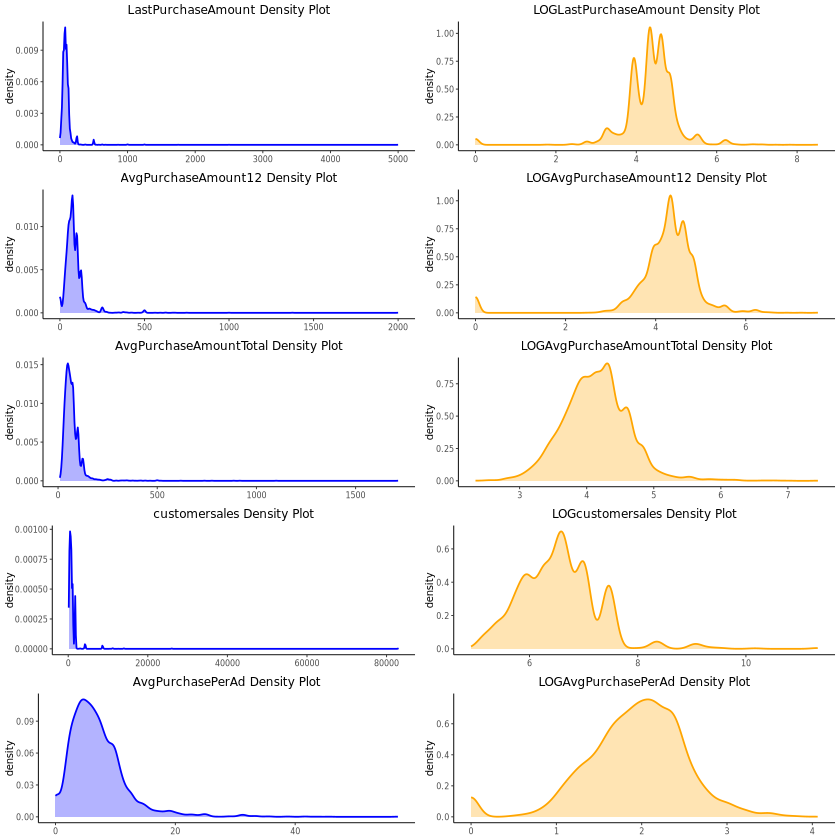

In [17]:
# Plots the difference between the distribution of the variables pre and post log transformation 

hist_compare(X_train, skewed_cols, log_cols)

In [18]:
# Updates the input list to include only log transformed columns

inputs <- c(setdiff(inputs, skewed_cols), log_cols)
numerics <- c(setdiff(numerics, skewed_cols), log_cols)


### One-Hot Encoding
One-Hot encodes the categorical column values.

In [19]:
# Fits a one hot encoder using the categorical columns
ohe <- dummyVars(~ ., data = X_train[, categoricals], fullRank = TRUE)

# Transforms both partitions

ohe_train <- predict(ohe, newdata = X_train[, categoricals])
ohe_test <- predict(ohe, newdata = X_test[, categoricals])

ohe_train <- as.data.frame(ohe_train)
ohe_test <- as.data.frame(ohe_test)

# Adds the new features to the partitions

ohe_features <- colnames(ohe_train)
X_train[ohe_features] <- ohe_train
X_test[ohe_features] <- ohe_test

In [20]:
# Drop non-OHE columns

X_train <- X_train[, !(colnames(X_train) %in% categoricals)]
X_test <- X_test[, !(colnames(X_test) %in% categoricals)]

# Update the inputs and categoricals lists

inputs <- c(setdiff(inputs, categoricals), ohe_features)
categoricals <- ohe_features

In [21]:
# Display sample of the output

head(X_train[, categoricals])

,customerGender.F,customerGender.M,customerSubscrStat.Gold,customerSubscrStat.Platinum,demHomeOwner.HomeOwner
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,1,0,0,1,0
2,0,1,0,1,1
3,1,0,0,1,1
4,1,0,0,1,0
5,1,0,0,1,1
6,0,1,0,1,0


### Variable Scaling
Scales the numeric columns based on their distribution.

In [22]:
# Standardizes the numeric columns so they have a similar scale

standardized_data <- scale(X_train[, numerics])

In [23]:
# Calculate means and sds from training data
train_means <- sapply(X_train[, numerics], mean, na.rm = TRUE)
train_sds   <- sapply(X_train[, numerics], sd, na.rm = TRUE)

# Standardize train and test data
X_train[, numerics] <- scale(X_train[, numerics], center = train_means, scale = train_sds)
X_test[, numerics]  <- scale(X_test[, numerics], center = train_means, scale = train_sds)


In [24]:
# Displays the distribution of the numeric variables

summary_stats <- summary(X_train[, numerics])
summary_stats

 regionPctCustomers numOfTotalReturns wksSinceLastPurch  
 Min.   :-2.7238    Min.   :-1.0127   Min.   :-3.016714  
 1st Qu.:-0.5396    1st Qu.:-1.0127   1st Qu.:-0.425916  
 Median :-0.0154    Median :-0.3424   Median : 0.005883  
 Mean   : 0.0000    Mean   : 0.0000   Mean   : 0.000000  
 3rd Qu.: 0.5962    3rd Qu.: 0.3280   3rd Qu.: 0.437683  
 Max.   : 3.9162    Max.   : 5.0203   Max.   : 1.948981  
 basktPurchCount12Month intAdExposureCount12 intAdExposureCount36
 Min.   :-1.3851        Min.   :-2.00196     Min.   :-2.7337     
 1st Qu.:-0.8070        1st Qu.:-0.43603     1st Qu.:-0.5502     
 Median :-0.2289        Median :-0.08804     Median : 0.2141     
 Mean   : 0.0000        Mean   : 0.00000     Mean   : 0.0000     
 3rd Qu.: 0.9272        3rd Qu.: 0.08595     3rd Qu.: 0.5416     
 Max.   : 3.8176        Max.   : 6.00171     Max.   : 4.2537     
 socialMediaAdCount12 socialMediaAdCount36 socialMediaAdCountAll
 Min.   :-2.6445      Min.   :-1.9123      Min.   :-1.76563     
 1

### Feature Selection
Performs supervised and unsupervised feature selection. Unsupervised feature selection technique used is variance threshold. Supervised feature selection technique used are lasso selection and a decision tree selector.

In [25]:
# Compute variance of each numeric feature
feature_vars <- apply(X_train[, inputs], 2, var)

# Keep features above threshold (0.1 in your example)
variance_features <- names(feature_vars[feature_vars > 0.1])

# Subset the training data if you want
X_train_filtered <- X_train[, variance_features]


In [26]:
# Unsupervised Variable Selection - Variance Threshold

variances <- apply(X_train[, inputs], 2, var)

threshold <- 0.1
variance_features <- names(variances[variances >= threshold])

In [27]:
# Backwards Elimination Variable Selection

set.seed(42)
ctrl <- rfeControl(functions = lrFuncs, method = "cv", number = 10)

rfe_result <- rfe(
  x = X_train[, inputs], 
  y = as.factor(y_train),
  sizes = seq_along(inputs),
  rfeControl = ctrl
)

rfe_features <- predictors(rfe_result)

In [28]:
#Dtree Variable Selection

set.seed(42)
tree_model <- rpart(y_train ~ ., data = X_train[, inputs, drop = FALSE])

importance_scores <- tree_model$variable.importance

tree_features <- names(importance_scores)


In [29]:
# Displays the removed features

all_features <- inputs  # assuming 'inputs' is your full starting feature list

rm_variance_features <- setdiff(all_features, variance_features)
rm_rfe_features <- setdiff(all_features, rfe_features)
rm_tree_features <- setdiff(all_features, tree_features)

cat("Variance Threshold Removed Features:\n\n")
print(rm_variance_features)

cat("\nRFE Removed Features:\n\n")
print(rm_rfe_features)

cat("\nDecision Tree Removed Features:\n\n")
print(rm_tree_features)

Variance Threshold Removed Features:

character(0)

RFE Removed Features:

[1] "intAdExposureCount36"        "socialMediaAdCount12"       
[3] "LOGAvgPurchasePerAd"         "customerGender.F"           
[5] "customerGender.M"            "customerSubscrStat.Gold"    
[7] "customerSubscrStat.Platinum" "demHomeOwner.HomeOwner"     

Decision Tree Removed Features:

[1] "wksSinceLastPurch"           "intAdExposureCount12"       
[3] "customerAge"                 "customerGender.F"           
[5] "customerGender.M"            "customerSubscrStat.Gold"    
[7] "customerSubscrStat.Platinum" "demHomeOwner.HomeOwner"     


In [30]:
# Selected features

selected_features <- inputs[
  inputs %in% variance_features |
  inputs %in% rfe_features |
  inputs %in% tree_features
]

selected_features

[1] "regionPctCustomers"          "numOfTotalReturns"          
 [3] "wksSinceLastPurch"           "basktPurchCount12Month"     
 [5] "intAdExposureCount12"        "intAdExposureCount36"       
 [7] "socialMediaAdCount12"        "socialMediaAdCount36"       
 [9] "socialMediaAdCountAll"       "totalNumProdPurchased"      
[11] "custInitiatedContacts"       "wksSinceFirstPurch"         
[13] "EstimatedIncome"             "regionMedHomeVal"           
[15] "techSupportEval"             "customerAge"                
[17] "LOGLastPurchaseAmount"       "LOGAvgPurchaseAmount12"     
[19] "LOGAvgPurchaseAmountTotal"   "LOGcustomersales"           
[21] "LOGAvgPurchasePerAd"         "customerGender.F"           
[23] "customerGender.M"            "customerSubscrStat.Gold"    
[25] "customerSubscrStat.Platinum" "demHomeOwner.HomeOwner"

In [31]:
# Create final training and testing data for model building
write_csv(cbind(trainID, y_train, X_train[,selected_features]), "../../data/output/customer_churn_ml_train_final.csv")
write_csv(cbind(testID, y_test, X_test[,selected_features]),  "../../data/output/customer_churn_ml_test_final.csv")